<a href="https://colab.research.google.com/github/Chri1629/dsim_project/blob/main/image/ambulanze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Progetto di Digital Signal & Image Management**

## **Parte 2 - Image Classification**

*2020/2021*

Peracchi Marco 800578

Uccheddu Christian 800428




# Abstract

La sezione di Image Classification si occupa di riconoscere da un'immagine se essa rappresenta o meno un mezzo di emergenza (ambulanze, polizia, vigili del fuoco etc), distinguendo questi mezzi da quelli comuni. Sono state utilizzate due reti per questo problema di classificazione. La prima rete è una **CNN definita da noi** mentre la seconda è una rete **pretrainata** sul task di imagenet.

# Operazioni di preprocessing

Importazione delle librerie necessarie:

In [1]:
import os
import numpy as np
from time import time
import re
import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import xception
from keras import layers

## Lettura dei dati e importazione

Per importare i dati si utilizza Drive:

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

base_dir = "gdrive/MyDrive/ambulanze/"

Mounted at /content/gdrive


Si procede a importare i dataset contenenti le informazioni sulle labels, ossia per ogni immagine è indicata a quale gruppo appartiene.

In [ ]:
trainAV = pd.read_csv("gdrive/MyDrive/train.csv")
testAV = pd.read_csv("gdrive/MyDrive/test_vc2kHdQ.csv")

** Le seguenti celle servono?? ** 

In [ ]:
print(len(trainAV) + len(testAV))

7290


In [ ]:
trainAV.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


Visto la disposizione di immagini e le corrispondenti label si definisce una funzione *add_class* che permetterà di definire in maniera corretta le varie immagini:

ATTENZIONE HO INSERITO UNA ROBA CHE NON SO SE FUNZIONA

In [ ]:
def add_class():
  # Ciclo for su ogni immagine presente nella cartella
  for i, f in enumerate(sorted(os.listdir(base_dir))):

    # Controllo sull'estensione del file
    if f.endswith('.jpg'):

      # Ricerca e acquisizione numero dell'immagine
      name = re.search(r'^(\d+)\.jpg$', f).group(1)
      
      # Lettura dell'immagine
      a = plt.imread(base_dir + f)      
      fig = plt.figure(figsize=(4,4))
      ax = fig.add_subplot(111)

      ax.imshow(a)

      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
      ax.set_frame_on(False)
      
      # Serie di if, se l'immagine letta è presente nel dataset train allora gli viene assegnata la label definita dal dataset
      if f in trainAV['image_names'].values:
        label = trainAV.loc[trainAV['image_names'] == f]['emergency_or_not'].values[0]
      
      # Se l'immagine è nel dataset test allora viene assegnata una label = 2
      elif f in testAV['image_names'].values:
        label = 2
      
      # Ora viene controllata la label appena assegnata
      # Se la label fosse 0 allora l'immagine viene salvata nella cartella corrispondente, e gli viene assegnato il nome salvato in precedenza
      if int(label) == 0:
          fig.savefig("gdrive/MyDrive/emergency_models/class_{}/{}.jpg".format(label, name), dpi = 100, bbox_inches = 'tight', pad_inches = 0)
      
      # Stessa procedura per la label 1
      elif int(label) == 1:
          fig.savefig("gdrive/MyDrive/emergency_models/class_{}/{}.jpg".format(label, name), dpi = 100, bbox_inches = 'tight', pad_inches = 0)
      
      # Infine se la label fosse 2 l'immagine viene inserita nel dataset di test
      elif int(label) == 2:
          fig.savefig("gdrive/MyDrive/emergency_models/class_test/{}.jpg".format(name), dpi = 100, bbox_inches = 'tight', pad_inches = 0)
    plt.close("all")
    print("Completato il: ", round(i/7290*100,2), "% dei file", end = "\r") #IN QUESTO PUNTO

In [ ]:
add_class()

Output streaming troncato alle ultime 5000 righe.
Completato il:  31.43 % dei file
Completato il:  31.44 % dei file
Completato il:  31.45 % dei file
Completato il:  31.47 % dei file
Completato il:  31.48 % dei file
Completato il:  31.5 % dei file
Completato il:  31.51 % dei file
Completato il:  31.52 % dei file
Completato il:  31.54 % dei file
Completato il:  31.55 % dei file
Completato il:  31.56 % dei file
Completato il:  31.58 % dei file
Completato il:  31.59 % dei file
Completato il:  31.6 % dei file
Completato il:  31.62 % dei file
Completato il:  31.63 % dei file
Completato il:  31.65 % dei file
Completato il:  31.66 % dei file
Completato il:  31.67 % dei file
Completato il:  31.69 % dei file
Completato il:  31.7 % dei file
Completato il:  31.71 % dei file
Completato il:  31.73 % dei file
Completato il:  31.74 % dei file
Completato il:  31.76 % dei file
Completato il:  31.77 % dei file
Completato il:  31.78 % dei file
Completato il:  31.8 % dei file
Completato il:  31.81 % dei fi

## Split train-validation-test

Per utilizzare il metodo *flow_from_directory* di keras è necessario che i file vengano divisi in sottocartelle, ognuna contentente le due classi distinte. Di seguito abbiamo utilizzato la libreria *splitfolders* per eseguire questa operazione velocemente ed efficientemente.

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("gdrive/MyDrive/emergency_models", output="gdrive/MyDrive/emergency_true_models", ratio=(0.6, 0.3, 0.1))


Copying files: 0 files [00:00, ? files/s]
Copying files: 1 files [00:00,  1.31 files/s]
Copying files: 12 files [00:00,  1.86 files/s]
Copying files: 23 files [00:01,  2.60 files/s]
Copying files: 32 files [00:01,  3.57 files/s]
Copying files: 48 files [00:01,  5.01 files/s]
Copying files: 62 files [00:01,  7.05 files/s]
Copying files: 70 files [00:01,  9.60 files/s]
Copying files: 83 files [00:02, 13.02 files/s]
Copying files: 98 files [00:02, 17.93 files/s]
Copying files: 108 files [00:02, 22.99 files/s]
Copying files: 117 files [00:02, 28.04 files/s]
Copying files: 133 files [00:02, 37.25 files/s]
Copying files: 144 files [00:02, 43.07 files/s]
Copying files: 154 files [00:02, 46.30 files/s]
Copying files: 165 files [00:03, 50.51 files/s]
Copying files: 179 files [00:03, 62.41 files/s]
Copying files: 189 files [00:03, 64.55 files/s]
Copying files: 198 files [00:03, 61.00 files/s]
Copying files: 211 files [00:03, 63.91 files/s]
Copying files: 226 files [00:03, 77.16 files/s]
Copying

# Reti neurali

Si definiscono ora le diverse tipologie di reti che sono state utilizzate

## XCEPTION 

La prima rete utilizzata è la **xception**.

Qui di seguito viene definita la funzione *acc_loss* utilizzata per meglio visualizzare i risultati dell'addestramento delle reti.

### Generator

Il **train_generator** viene definito con le stesse operazione di preprocessing utilizzate dalla Xception. Ulteriori opzioni definite sono la *batch_size* uguale a 32 e lo *shuffle* viene settato a True.

Non sono state definite operazioni di *data augmentation* in quanto il dataset di immagini che è stato utilizzato presentava già operazioni di augmentation.

In [3]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = xception.preprocess_input)

train_generator = train_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/train",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1)

Found 3950 images belonging to 2 classes.


Vengono definiti **validation_generator** e **test_generator**.

In [4]:
validation_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

validation_generator = validation_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/val",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

Found 1975 images belonging to 2 classes.


In [5]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

test_generator = test_processing.flow_from_directory("gdrive/MyDrive/emergency_true_models/test",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

Found 659 images belonging to 2 classes.


 ### Definizione della rete

 Viene importata la rete senza includere l'ultimo layer, in quanto sarà necessario adattarlo alle nostre esigenze, ovvero l'output desiderato.

In [6]:
base_net = xception.Xception(input_shape = (224,224,3),
                        weights = 'imagenet',
                        include_top = False,
                        pooling = 'avg')

Vengono congelati i layer della rete, in quanto la rete è stata preaddestrata, gli unici pesi che andranno a modificarsi saranno quelli corrispondenti ai layer aggiunti.

In [7]:
for layer in base_net.layers:
    layer.trainable = False

Si aggiungono due layer, entrambi **dense**, il primo con attivazione **RELU** e il secondo con attivazione **sigmoid**. Ovviamente, avendo solo due classi da predire, l'ultimo layer presenta solo due neuroni.

In [8]:
x = base_net.output

x = keras.layers.Dense(64, activation = "relu") (x)
pred = keras.layers.Dense(2, activation = 'sigmoid') (x)

In [9]:
net1 = keras.Model(inputs = base_net.input, outputs = pred)

In [10]:
net1.compile(loss = keras.losses.categorical_crossentropy,
           optimizer = keras.optimizers.Adam(),
           metrics = ['accuracy'])

hist1 = net1.fit(train_generator,
       epochs = 20,
       batch_size = 32,
       validation_data = validation_generator)

Epoch 1/20
124/124 [==============================] - 340s 3s/step - loss: 0.2928 - accuracy: 0.8645 - val_loss: 0.1827 - val_accuracy: 0.9271
Epoch 2/20
124/124 [==============================] - 32s 256ms/step - loss: 0.1687 - accuracy: 0.9359 - val_loss: 0.1760 - val_accuracy: 0.9316
Epoch 3/20
124/124 [==============================] - 30s 240ms/step - loss: 0.1411 - accuracy: 0.9449 - val_loss: 0.2213 - val_accuracy: 0.9119
Epoch 4/20
124/124 [==============================] - 30s 241ms/step - loss: 0.1254 - accuracy: 0.9544 - val_loss: 0.2150 - val_accuracy: 0.9119
Epoch 5/20
124/124 [==============================] - 31s 247ms/step - loss: 0.1184 - accuracy: 0.9546 - val_loss: 0.2657 - val_accuracy: 0.9129
Epoch 6/20
124/124 [==============================] - 30s 244ms/step - loss: 0.1319 - accuracy: 0.9478 - val_loss: 0.1617 - val_accuracy: 0.9347
Epoch 7/20
124/124 [==============================] - 30s 244ms/step - loss: 0.0747 - accuracy: 0.9741 - val_loss: 0.1643 - val_accu

Si procede all'addestramento della rete.

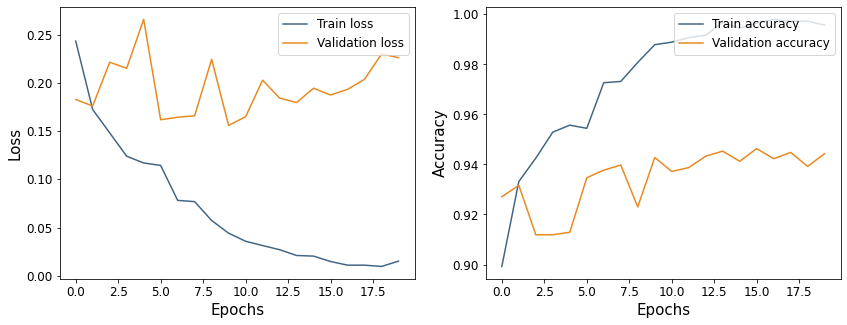

In [11]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(hist1.history['loss'], label = "Train loss", color = "#416685")
plt.plot(hist1.history['val_loss'], label="Validation loss", color = "#E88920")
plt.legend(loc='upper right', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Epochs', size = 15)
plt.ylabel('Loss', size = 15) 

plt.subplot(1,2,2)
plt.plot(hist1.history['accuracy'], label = "Train accuracy", color = "#416685")
plt.plot(hist1.history['val_accuracy'], label="Validation accuracy", color = "#E88920")
plt.legend(loc='upper right', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Epochs', size = 15)
plt.ylabel('Accuracy', size = 15) 
fig.savefig("loss_accuracy_xception.png", dpi = 300)

In [12]:
acc1 = net1.evaluate(test_generator)

21/21 [==============================] - 170s 8s/step - loss: 0.1735 - accuracy: 0.9545


Calcoliamo ora i risultati per visalizzare la matrice di confusione e meglio capire i risultati.

In [13]:
pred_1 = net1.predict(test_generator)

In [14]:
pred_1 = np.argmax(pred_1, axis = 1)

In [15]:
print(classification_report(test_generator.classes, pred_1))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       386
           1       0.93      0.96      0.95       273

    accuracy                           0.95       659
   macro avg       0.95      0.96      0.95       659
weighted avg       0.96      0.95      0.95       659



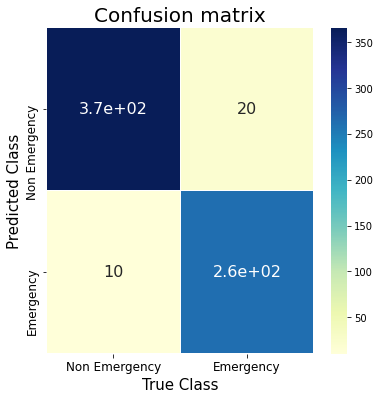

In [16]:
cm = confusion_matrix(test_generator.classes, pred_1)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Non Emergency', 'Emergency']) 
ax.xaxis.set_ticklabels(['Non Emergency', 'Emergency']) 

plt.title("Confusion matrix", size = 20)
fig.savefig("confusion_matrix_xception.png", dpi = 200)

In [17]:
net1.save('gdrive/MyDrive/modello_immagini')

INFO:tensorflow:Assets written to: gdrive/MyDrive/modello_immagini/assets


## CNN

Viene ora definita una rete convoluzionale e si procede all'addestramento.

In [ ]:
model = keras.Sequential(
    [
     keras.Input(shape = (224,224,3)),
     layers.Conv2D(16, kernel_size = (3,3), activation = 'relu'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(16, kernel_size = (3,3), activation = 'relu'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Flatten(),
     layers.Dense(124, activation = "relu"),
     layers.Dropout(0.5),
     layers.Dense(2, activation = 'softmax')
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 109, 109, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 46656)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 124)               5785468   
_________________________________________________________________
dropout_2 (Dropout)          (None, 124)              

In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer = keras.optimizers.Adam(),
              metrics = ["accuracy"])

histo_best = model.fit(train_generator, 
                       epochs = 20, 
                       batch_size = 32, 
                       validation_data = validation_generator)

Epoch 1/20
124/124 [==============================] - 22s 179ms/step - loss: 1.2323 - accuracy: 0.6265 - val_loss: 0.5713 - val_accuracy: 0.7129
Epoch 2/20
124/124 [==============================] - 22s 174ms/step - loss: 0.5057 - accuracy: 0.7544 - val_loss: 0.5493 - val_accuracy: 0.7210
Epoch 3/20
124/124 [==============================] - 21s 173ms/step - loss: 0.4137 - accuracy: 0.8236 - val_loss: 0.5164 - val_accuracy: 0.7646
Epoch 4/20
124/124 [==============================] - 21s 173ms/step - loss: 0.3075 - accuracy: 0.8753 - val_loss: 0.5573 - val_accuracy: 0.7747
Epoch 5/20
124/124 [==============================] - 22s 175ms/step - loss: 0.1976 - accuracy: 0.9249 - val_loss: 0.5875 - val_accuracy: 0.7686
Epoch 6/20
124/124 [==============================] - 22s 175ms/step - loss: 0.1449 - accuracy: 0.9504 - val_loss: 0.7370 - val_accuracy: 0.7565
Epoch 7/20
124/124 [==============================] - 21s 173ms/step - loss: 0.1115 - accuracy: 0.9627 - val_loss: 0.8191 - val_ac

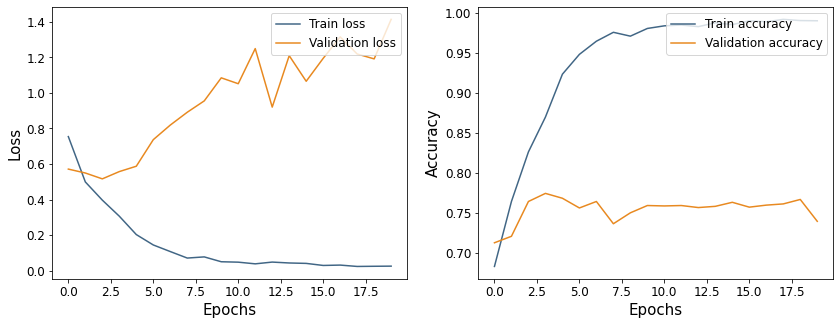

In [ ]:
fig = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(histo_best.history['loss'], label = "Train loss", color = "#416685")
plt.plot(histo_best.history['val_loss'], label="Validation loss", color = "#E88920")
plt.legend(loc='upper right', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Epochs', size = 15)
plt.ylabel('Loss', size = 15) 

plt.subplot(1,2,2)
plt.plot(histo_best.history['accuracy'], label = "Train accuracy", color = "#416685")
plt.plot(histo_best.history['val_accuracy'], label="Validation accuracy", color = "#E88920")
plt.legend(loc='upper right', fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Epochs', size = 15)
plt.ylabel('Accuracy', size = 15) 
fig.savefig("loss_accuracy_cnn.png", dpi = 300)

In [ ]:
acc_best = model.evaluate(test_generator)

21/21 [==============================] - 2s 111ms/step - loss: 1.4262 - accuracy: 0.7481


Come precedentemente si calcolano le previsioni per visualizzare la matrice di confusione.

In [ ]:
yc_pred = model.predict(test_generator)
y_pred_best = np.argmax(yc_pred, axis = 1)

In [ ]:
print(classification_report(test_generator.classes, y_pred_best))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       386
           1       0.68      0.75      0.71       273

    accuracy                           0.75       659
   macro avg       0.74      0.75      0.74       659
weighted avg       0.75      0.75      0.75       659



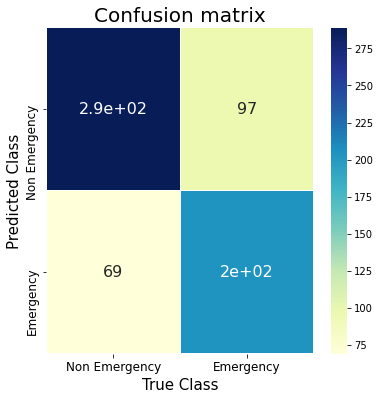

In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred_best)
fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Non Emergency', 'Emergency']) 
ax.xaxis.set_ticklabels(['Non Emergency', 'Emergency']) 

plt.title("Confusion matrix", size = 20)
fig.savefig("confusion_matrix_cnn_scratch.png", dpi = 200)

# Demo

Per effettuare una demo viene definito un generator:

In [ ]:
single_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

single_generator = single_processing.flow_from_directory("gdrive/MyDrive/single",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 13,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

test,label_test = next(single_generator)

Found 13 images belonging to 1 classes.


Viene caricato il modello salvato precedentemente:

In [ ]:
net_finale = tf.keras.models.load_model('gdrive/MyDrive/modello_bello')

Si producono le previsioni:

In [ ]:
prova_pred = net_finale.predict(single_generator)
result = np.argmax(prova_pred, axis = 1)
result

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1])

In [ ]:
labels = (train_generator.class_indices).copy()
labels['Not Emergency'] = labels['class_0']
labels['Emergency'] = labels['class_1']

del labels['class_0']
del labels['class_1']

labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in result]

In [ ]:
predictions

['Emergency',
 'Emergency',
 'Emergency',
 'Not Emergency',
 'Emergency',
 'Emergency',
 'Emergency',
 'Emergency',
 'Emergency',
 'Not Emergency',
 'Not Emergency',
 'Emergency',
 'Emergency']

La classe 1 è quella dei veicoli di emergenza

In [ ]:
prova_pred

array([[0.09320138, 0.9928631 ],
       [0.78175384, 0.757487  ],
       [0.15241091, 0.9383376 ],
       [0.07533869, 0.98778   ],
       [0.7092192 , 0.894524  ],
       [0.9265203 , 0.20975761],
       [0.97900635, 0.38344505],
       [0.30680335, 0.952226  ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predizione: Emergency')

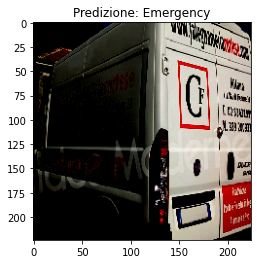

In [ ]:
plt.imshow(test[0,:,:,:])
plt.title("Predizione: {}".format(predictions[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

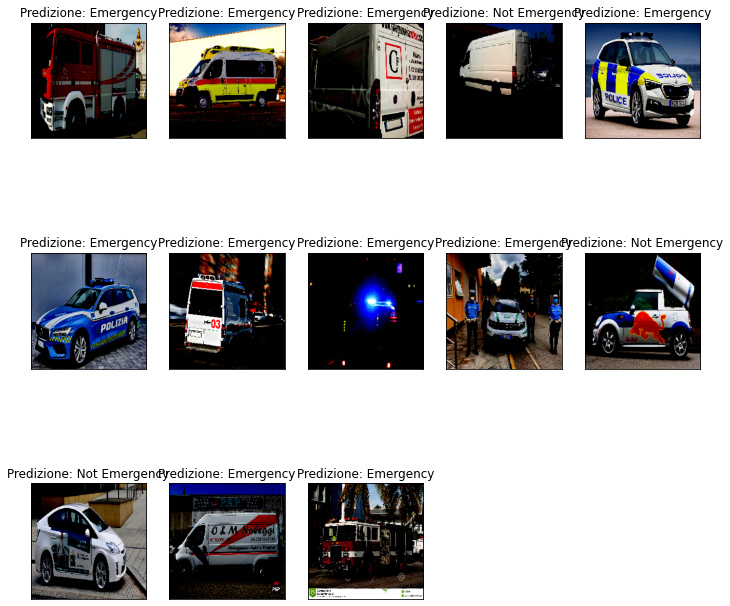

In [ ]:
fig = plt.figure(figsize = (12,12))

for i, immagine in enumerate(test):
  fig.add_subplot(3,5,i+1)
  plt.imshow(immagine)
  plt.title("Predizione: {}".format(predictions[i]))
  plt.tick_params(axis='both', which='both', bottom=False, top=False, left = False,
                  right = False, labelbottom=False, labelleft=False)
  